In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
from astropy.io import fits
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

In [2]:
vsun = coord.CartesianDifferential([11.1, 251.24, 7.25]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, galcen_v_sun=vsun)

In [3]:
mike_data = Table.read('../data/mike_results.fits')
mike_data['pw1_id'] = [int(x.strip()[-2:]) if 'pw' in x else 9999 for x in mike_data['NAME']]

data = Table.read('../output/pw1-region-data-joined.fits')
data['pw1_id'] = [int(x.strip()[-2:]) if 'PW' in x else 9999 for x in data['pw1_name']]

In [4]:
tbl = join(data, mike_data, keys='pw1_id')
tbl = tbl[tbl['pw1_name'] != '']

In [5]:
all_c = coord.SkyCoord(ra=tbl['ra']*u.deg,
                       dec=tbl['dec']*u.deg,
                       distance=28.7*u.kpc,
                       pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                       pm_dec=tbl['pmdec']*u.mas/u.yr,
                       radial_velocity=tbl['VHELIO']*u.km/u.s)

### Pick the average orbit of the main clump:

In [6]:
clump_c = all_c[np.abs(all_c.dec - np.median(all_c.dec)) < 0.25*u.deg]
avg_c = coord.SkyCoord(ra=np.median(clump_c.ra),
                       dec=np.median(clump_c.dec),
                       distance=29*u.kpc,
                       pm_ra_cosdec=np.median(clump_c.pm_ra_cosdec),
                       pm_dec=np.median(clump_c.pm_dec),
                       radial_velocity=np.median(clump_c.radial_velocity))

In [7]:
galcen = avg_c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)
pot = gp.MilkyWayPotential()

### Compute the orbit in a Milky Way model without drag:

In [8]:
orbit_nodrag = pot.integrate_orbit(w0, dt=-0.1, n_steps=2000)
w0_zeq0 = orbit_nodrag[np.abs(orbit_nodrag.z).argmin()]
t_zeq0 = orbit_nodrag.t[np.abs(orbit_nodrag.z).argmin()]
t_zeq0

<Quantity -71.9 Myr>

Estimate the drag acceleration by assuming a cloud surface density, milky way halo density (Miller & Bregman 2013, and see [this paper](https://iopscience.iop.org/article/10.1088/0004-637X/815/1/77/pdf)):

$$
a_{\rm ram} = \rho_{\rm MW} \, v^2 \, m_H^{-1} \, \Sigma_{cloud}^{-1}
$$

In [9]:
from astropy.constants import m_p

In [92]:
surf_dens = 50 * u.Msun/u.pc**2

def n_mw(r):
    n0 = 0.46 / u.cm**3
    rc = 350*u.pc
    beta = 0.71
    return n0 * (1 + (r/rc)**2) ** (-1.5 * beta)

mw_dens = 1e3 * (m_p * n_mw(17*u.kpc)).to(u.g/u.cm**3)
fac = (mw_dens / surf_dens).to_value(1/u.kpc)
fac

0.05814732447960793

In [93]:
def F(t, w):
    x, y, z, vx, vy, vz = w
    
    q = np.vstack([x, y, z])
    p = np.vstack([vx, vy, vz])
    
    # compute acceleration from milky way
    # acc = -pot._gradient(q, t=np.array([0.]))
    # acc = pot.acceleration(q).value
    acc = -pot._gradient(np.ascontiguousarray(q.T), np.array([0.])).T
    
    # compute drag acceleration
    # velocity units here are in kpc/Myr
    acc_drag = fac * np.sum(p**2, axis=0)
    
    # in the direction opposite of motion
    acc_drag = -acc_drag * p / np.sqrt(np.sum(p**2, axis=0))[None]
    
    return np.vstack((p, acc + acc_drag))

In [90]:
integrator = gi.DOPRI853Integrator(F, func_units=galactic)
orbit_drag = integrator.run(w0_zeq0, dt=0.1, t1=t_zeq0, t2=0)

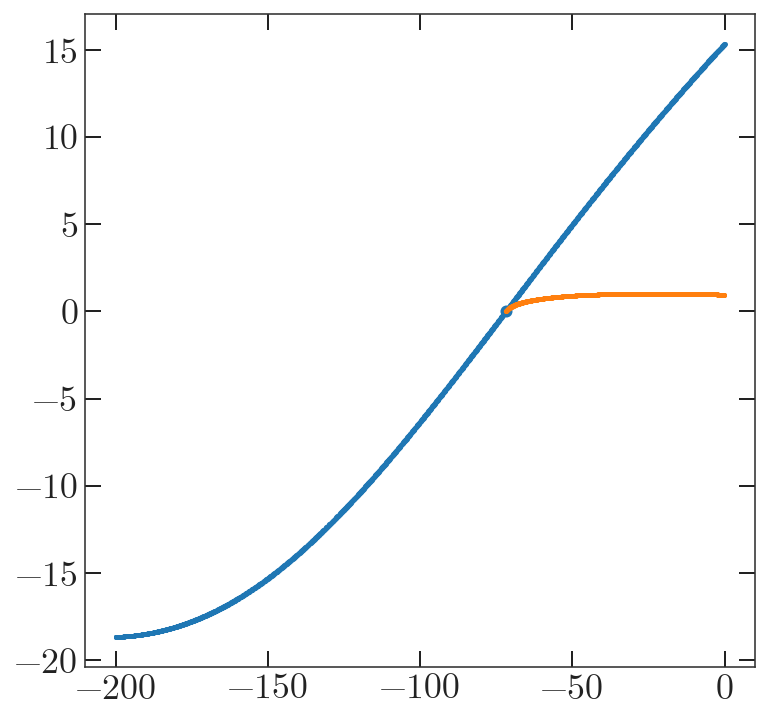

In [91]:
plt.plot(orbit_nodrag.t, orbit_nodrag.z)
plt.plot(orbit_drag.t, orbit_drag.z)
plt.scatter(t_zeq0, w0_zeq0.z)

In [86]:
orbit_nodrag_c = orbit_nodrag.to_coord_frame(gc.MagellanicStreamNidever08, galactocentric_frame=galcen_frame)
orbit_drag_c = orbit_drag.to_coord_frame(gc.MagellanicStreamNidever08, galactocentric_frame=galcen_frame)

(10, 40)

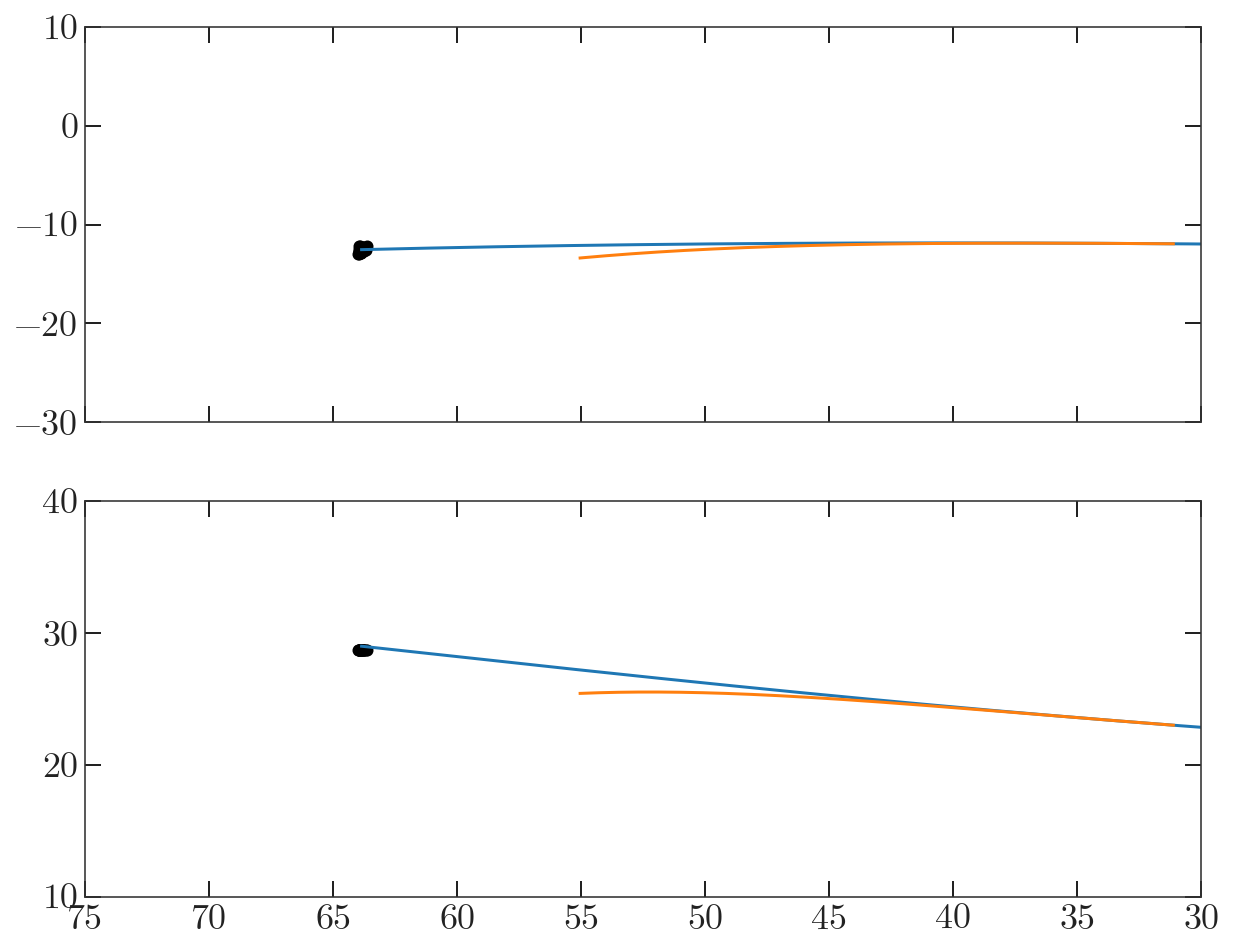

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), 
                         sharex=True)

ax = axes[0]
mag_clump_c = clump_c.transform_to(gc.MagellanicStreamNidever08)
ax.scatter(mag_clump_c.L.degree, mag_clump_c.B.degree, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.B.degree, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.B.degree, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(-30, 10)

# ---

ax = axes[1]
ax.scatter(mag_clump_c.L.degree, mag_clump_c.distance.value, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.distance.value, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.distance.value, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(10, 40)